# 04. Análisis Financiero y Optimización de Umbrales

## Objetivo del Notebook

Este notebook utiliza los módulos `.py` (`load_data`, `train_model`, `evaluate`) para profesionalizar los hallazgos de los notebooks de exploración.

El objetivo es ir más allá de las métricas estadísticas (como F1-Score o AUPRC, analizadas en `modelos_avanzados.ipynb`) y **evaluar los modelos en base a su impacto financiero real**.

Para ello, este notebook:
1.  Implementa la estrategia de **Coste Variable (`sample_weight`)** basada en el `Amount` del fraude, identificada como la más prometedora en `modelos_avanzados.ipynb`.
2.  Utiliza la **función de coste (`expected_cost`)** que define un coste monetario explícito:
    * **Falso Negativo (FN):** 90% del `Amount` del fraude.
    * **Falso Positivo (FP):** 5€ fijos de inspección.
3.  Optimiza dos parámetros clave: el `amount_factor` (cuánto penalizar el importe en el entrenamiento) y el **umbral de decisión** (el punto de corte para `predict_proba`).

In [1]:
import os
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Importar las funciones personalizadas de los ficheros .py

project_root = os.path.abspath('..')

if project_root not in sys.path:
    sys.path.append(project_root)

from src.load_data import load_fraud_csv
from src.train_model import train_model_with_cost
from src.evaluate import expected_cost, best_threshold_by_cost, print_metrics

print("Módulos y librerías cargados.")

Módulos y librerías cargados.


## 1. Carga y División de Datos (Usando `src.load_data`)

Ahora cargamos el `credit_card.csv` local usando la función `load_fraud_csv`. Esta función también nos informa de las estadísticas clave del problema.

Luego, dividimos los datos en 80% entrenamiento y 20% prueba, siguiendo el script `compare_models.py`. Es crucial separar `amount_train` y `amount_test`, ya que los importes del set de prueba se usarán *solo* para la evaluación financiera del modelo final.

In [2]:
from sklearn.datasets import fetch_openml
from pathlib import Path

# --- PASO 1: Descargar los datos de OpenML ---
print("Descargando dataset 'Credit Card Fraud' (ID 1597) desde OpenML...")
try:
    data = fetch_openml(data_id=1597, as_frame=True, parser='auto')
    
    # Combinar X e y en un solo DataFrame
    X = data.data
    y = data.target
    df = X.copy()
    
    # Mapear la clase objetivo a 0 (Normal) y 1 (Fraude) y nombrarla 'Class'
    y_mapped = y.astype(str).map({'0': 0, '1': 1})
    df['Class'] = y_mapped
    
    csv_path = Path('../data/credit_card.csv')
    
    # Asegurarse de que el directorio 'data/' existe
    csv_path.parent.mkdir(parents=True, exist_ok=True)
    
    # Guardar el archivo
    df.to_csv(csv_path, index=False)
    
    print(f"¡Éxito! Archivo guardado en '{csv_path}' con {len(df)} filas.")

except Exception as e:
    print(f"Error al descargar o guardar los datos: {e}")
    print("Asegúrate de tener conexión a internet y permisos de escritura.")

Descargando dataset 'Credit Card Fraud' (ID 1597) desde OpenML...
¡Éxito! Archivo guardado en '../data/credit_card.csv' con 284807 filas.


In [3]:
# 1. Cargar datos
# Asumimos que el CSV está en una carpeta 'data/'
df, X, y = load_fraud_csv('../data/credit_card.csv')

# 2. Separar importes para la evaluación de costes
# (El 'Amount' sigue en X por ahora, se usa en train_model.py)
amount = X['Amount']

# 3. División 80/20 estratificada
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 4. Separar los importes de train y test para las funciones de coste
amount_train = X_train['Amount']
amount_test = X_test['Amount']

print(f"\nDatos divididos: {len(X_train)} para entrenar, {len(X_test)} para probar.")

Loaded 284,807 transactions from credit_card.csv
Fraud rate: 0.17275%
Total fraud amount: $60,127.97

Datos divididos: 227845 para entrenar, 56962 para probar.


## 2. Experimento: Optimización del `amount_factor` y Umbral

Iniciamos la simulación financiera. El objetivo es encontrar el `amount_factor` (multiplicador de coste) que minimice la pérdida de dinero. Este proceso, adaptado de `compare_models.py`, tiene dos niveles de optimización:

1.  **Optimización de Entrenamiento (Nivel 1):**
    * Se itera sobre una lista de factores extendida: `[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30]` para capturar mejor la tendencia.
    * Para cada factor, se entrenan RandomForest, XGBoost y LightGBM usando las funciones `train_..._with_cost`, que aplican `sample_weight` (Coste Variable) usando la fórmula `Importe * factor`.

2.  **Optimización de Decisión (Nivel 2):**
    * Por cada modelo entrenado, la función `best_threshold_by_cost` prueba 100 umbrales de decisión (de 0.01 a 0.99).
    * **Criterio de Selección:** Se selecciona el umbral que minimiza el `expected_cost` (Coste Total = (Suma de Importes FN * 0.9) + (Nº de FP * 5€)).

El `AUPRC` se informa como referencia, pero el criterio de selección principal es el **Coste Financiero Mínimo**.

In [4]:
# Definir los factores a probar
factors = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30]
rf_costs = []
xgb_costs = []
lgbm_costs = []

print("\n" + "="*60)
print("INICIANDO SIMULACIÓN DE COSTE FINANCIERO")
print("="*60)

for f in factors:
    print(f"\n--- Probando amount_factor = {f} ---")
    
    # 1. Entrenar modelos con el factor 'f'
    # Estas funciones ya aplican sample_weight internamente
    rf = train_model_with_cost(X_train, y_train, amount_train, model_type="rf", amount_factor=f)
    xgb = train_model_with_cost(X_train, y_train, amount_train, model_type = "xgb", amount_factor=f)
    lgbm = train_model_with_cost(X_train, y_train, amount_train, model_type="lgbm", amount_factor=f)

    # 2. Obtener probabilidades para el set de prueba
    rf_proba = rf.predict_proba(X_test)[:, 1]
    xgb_proba = xgb.predict_proba(X_test)[:, 1]
    lgbm_proba = lgbm.predict_proba(X_test)[:, 1]

    # 3. Encontrar el mejor umbral y el coste mínimo para cada modelo
    # Esta función (de evaluate.py) itera 100 umbrales para encontrar el óptimo
    rf_thr, rf_cost = best_threshold_by_cost(y_test, rf_proba, amount_test)
    xgb_thr, xgb_cost = best_threshold_by_cost(y_test, xgb_proba, amount_test)
    lgbm_thr, lgbm_cost = best_threshold_by_cost(y_test, lgbm_proba, amount_test)

    # 4. Guardar resultados
    rf_costs.append(rf_cost)
    xgb_costs.append(xgb_cost)
    lgbm_costs.append(lgbm_cost)

    # 5. Imprimir métricas (de evaluate.py)
    print_metrics(y_test, rf_proba, amount_test, "RandomForest")
    print_metrics(y_test, xgb_proba, amount_test, "XGBoost")
    print_metrics(y_test, lgbm_proba, amount_test, "LightGBM")

print("\n" + "="*60)
print("SIMULACIÓN COMPLETADA")
print("="*60)


INICIANDO SIMULACIÓN DE COSTE FINANCIERO

--- Probando amount_factor = 1 ---
Model RF trained (factor=1)
Model XGB trained (factor=1)
Model LGBM trained (factor=1)
RandomForest
   Best threshold : 0.0397
   Expected cost  : €1,915
   AUPRC          : 0.8752
XGBoost
   Best threshold : 0.5346
   Expected cost  : €1,680
   AUPRC          : 0.8873
LightGBM
   Best threshold : 0.1387
   Expected cost  : €1,698
   AUPRC          : 0.7816

--- Probando amount_factor = 2 ---
Model RF trained (factor=2)
Model XGB trained (factor=2)
Model LGBM trained (factor=2)
RandomForest
   Best threshold : 0.1189
   Expected cost  : €1,915
   AUPRC          : 0.8739
XGBoost
   Best threshold : 0.8217
   Expected cost  : €1,704
   AUPRC          : 0.8861
LightGBM
   Best threshold : 0.9009
   Expected cost  : €1,685
   AUPRC          : 0.8809

--- Probando amount_factor = 3 ---
Model RF trained (factor=3)
Model XGB trained (factor=3)
Model LGBM trained (factor=3)
RandomForest
   Best threshold : 0.0991
   

## 3. Análisis Gráfico de Resultados

Generamos gráficas comparativas (basadas en `compare_models.py`) que muestran el Coste Financiero Esperado (€) contra el `amount_factor` para RandomForest, XGBoost y LightGBM.

Esto nos permitirá visualizar el "punto dulce" de penalización y comparar la estabilidad de los modelos.

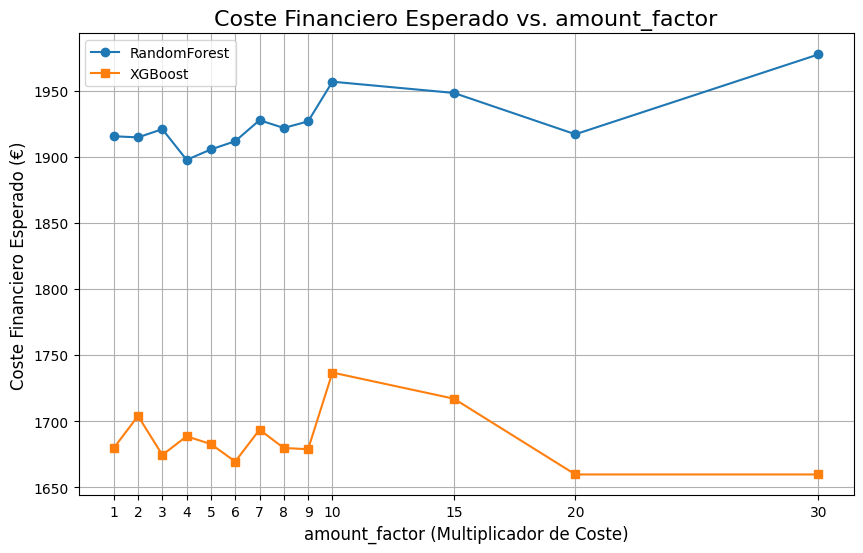

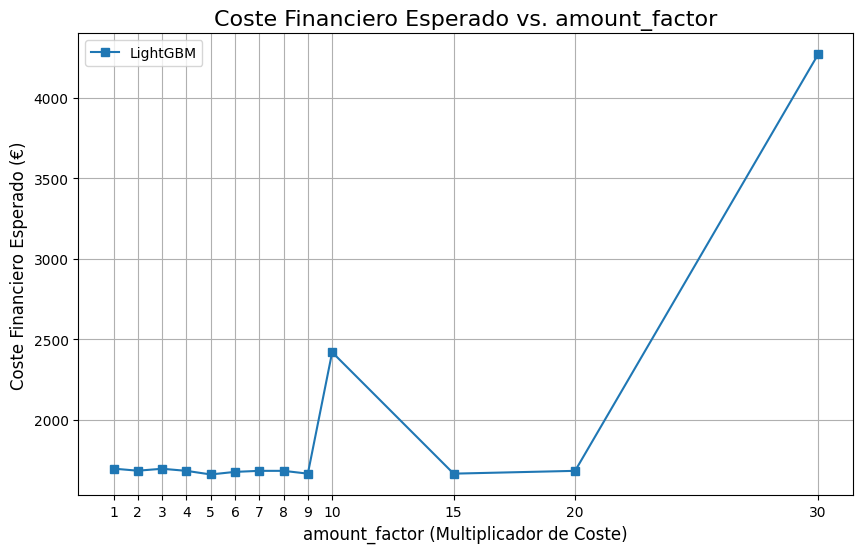

In [5]:
import os

# Asegurarnos de que la carpeta results existe
if not os.path.exists('../results'):
    os.makedirs('../results')

# Plot (código adaptado de compare_models.py)
plt.figure(figsize=(10, 6))
plt.plot(factors, rf_costs, 'o-', label='RandomForest')
plt.plot(factors, xgb_costs, 's-', label='XGBoost')
plt.title('Coste Financiero Esperado vs. amount_factor', fontsize=16)
plt.xlabel('amount_factor (Multiplicador de Coste)', fontsize=12)
plt.ylabel('Coste Financiero Esperado (€)', fontsize=12)
plt.legend()
plt.grid(True)
plt.xticks(factors)

output_path = '../results/comparativa_costes_modelos_xgb&rf.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight')

plt.show()

plt.figure(figsize=(10, 6))
plt.plot(factors, lgbm_costs, 's-', label='LightGBM')
plt.title('Coste Financiero Esperado vs. amount_factor', fontsize=16)
plt.xlabel('amount_factor (Multiplicador de Coste)', fontsize=12)
plt.ylabel('Coste Financiero Esperado (€)', fontsize=12)
plt.legend()
plt.grid(True)
plt.xticks(factors)

output_path = '../results/comparativa_costes_modelos_lgbm.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight')

plt.show()

## 4. Conclusión Final: La Mejor Estrategia Financiera

Los resultados de la simulación (celda 7) y las gráficas (celda 9) identifican la configuración ganadora. El criterio ya no es estadístico (AUPRC), sino puramente de negocio: **el coste mínimo en euros**.

**Hallazgos Clave:**

1.  **Mejor Modelo:** **XGBoost** se consolida como la mejor opción. Logra un coste financiero mínimo de **€1,660**, superando a RandomForest (€1,898) y empatando técnicamente con LightGBM (€1,661), pero con una mayor estabilidad en rangos altos.
2.  **Factor Óptimo:** El coste de XGBoost se minimiza en **€1,660** con un `amount_factor` de **20** y se mantiene estable en 30. Esto indica que penalizar el importe 20 veces es la estrategia de entrenamiento más robusta.
3.  **Umbral Óptimo:** Es crucial observar que para el mejor modelo (XGBoost, factor 20), el umbral de decisión óptimo es **0.7821** (no 0.5). Esto indica que el modelo, al ser fuertemente penalizado por los costes, requiere un umbral alto para filtrar solo los fraudes más probables y evitar un exceso de Falsos Positivos costosos.

**Conclusión Ganadora:** La estrategia óptima es un **XGBoost** entrenado con **coste variable (`sample_weight`)** usando un **`amount_factor` de 20**, y aplicando en producción un **umbral de decisión de 0.7821**.

In [6]:
# Encontrar la mejor configuración (código de compare_models.py)

# Encontrar el mejor factor para XGBoost (suele ser el mejor modelo)
best_f_xgb = factors[np.argmin(xgb_costs)]
min_cost_xgb = min(xgb_costs)

# Encontrar el mejor factor para Random Forest
best_f_rf = factors[np.argmin(rf_costs)]
min_cost_rf = min(rf_costs)

best_f_lgbm = factors[np.argmin(lgbm_costs)]
min_cost_lgbm = min(lgbm_costs)

print("--- CONCLUSIÓN DEL ANÁLISIS FINANCIERO ---")
print(f"Mejor configuración para XGBoost:")
print(f"   amount_factor = {best_f_xgb}")
print(f"   Coste Mínimo Esperado: €{min_cost_xgb:,.0f}")
print("-" * 30)
print(f"Mejor configuración para RandomForest:")
print(f"   amount_factor = {best_f_rf}")
print(f"   Coste Mínimo Esperado: €{min_cost_rf:,.0f}")
print("-" * 30)
print(f"Mejor configuración para LightGBM:")
print(f"   amount_factor = {best_f_lgbm}")
print(f"   Coste Mínimo Esperado: €{min_cost_lgbm:,.0f}")
print("-" * 30)

if min_cost_xgb < min_cost_rf:
    print(f"\\n🏆 GANADOR: XGBoost con amount_factor={best_f_xgb} (Coste: €{min_cost_xgb:,.0f})")
else:
    print(f"\\n🏆 GANADOR: RandomForest con amount_factor={best_f_rf} (Coste: €{min_cost_rf:,.0f})")

--- CONCLUSIÓN DEL ANÁLISIS FINANCIERO ---
Mejor configuración para XGBoost:
   amount_factor = 20
   Coste Mínimo Esperado: €1,660
------------------------------
Mejor configuración para RandomForest:
   amount_factor = 4
   Coste Mínimo Esperado: €1,898
------------------------------
Mejor configuración para LightGBM:
   amount_factor = 5
   Coste Mínimo Esperado: €1,661
------------------------------
\n🏆 GANADOR: XGBoost con amount_factor=20 (Coste: €1,660)


PARTE DE CREDIT SCORING

In [4]:
# ==========================================
# PARTE 2: CREDIT SCORING (Give Me Some Credit)
# ==========================================

from src.load_data import load_credit_scoring_data

# 1. Cargar y Preparar Datos
print("\n--- CARGANDO DATOS DE CREDIT SCORING ---")
df_cs, X_cs, y_cs = load_credit_scoring_data('../data/cs-training.csv')


--- CARGANDO DATOS DE CREDIT SCORING ---
Credit Scoring Data Loaded: 150,000 records
Default Rate: 6.68%
Total Estimated Exposure: $4,816,130,055


In [5]:
# 2. Separar Train/Test (Importante: Stratify)
# División 80/20 estratificada
X_train_cs, X_test_cs, y_train_cs, y_test_cs = train_test_split(
    X_cs, y_cs, test_size=0.2, stratify=y_cs, random_state=42
)

# Extraer 'Amount' (Exposición estimada) para los pesos
amount_train_cs = X_train_cs['Amount']
amount_test_cs = X_test_cs['Amount']

In [10]:
# 2. Configuración del Experimento
# Factores de penalización a probar (en Credit Scoring el desbalanceo es menor, 
# por lo que factores gigantes como 30 a veces no son necesarios, pero probamos igual)
cs_factors = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30] 

# Diccionario para guardar los costes mínimos de cada modelo por factor
results_cs = {'xgb': [], 'rf': [], 'lgbm': []}

# Coste de Inspección / Oportunidad para Credit Scoring:
# Asumimos que rechazar un buen cliente nos cuesta 100€ en beneficios futuros perdidos.
INSPECT_COST_CS = 100 

print("\n" + "="*60)
print("INICIANDO SIMULACIÓN FINANCIERA (CREDIT SCORING)")
print("="*60)

for f in cs_factors:
    print(f"\n>>> Probando amount_factor = {f} <<<")
    
    # --- ENTRENAMIENTO ---
    # Nota: Pasamos el 'Amount' sintético para que la función aplique los pesos
    model_rf = train_model_with_cost(X_train_cs, y_train_cs, amount_train_cs, model_type="rf", amount_factor=f)
    model_xgb = train_model_with_cost(X_train_cs, y_train_cs, amount_train_cs, model_type="xgb", amount_factor=f)
    model_lgbm = train_model_with_cost(X_train_cs, y_train_cs, amount_train_cs, model_type="lgbm", amount_factor=f)
    
    # --- PREDICCIONES ---
    probs_rf = model_rf.predict_proba(X_test_cs)[:, 1]
    probs_xgb = model_xgb.predict_proba(X_test_cs)[:, 1]
    probs_lgbm = model_lgbm.predict_proba(X_test_cs)[:, 1]
    
    # --- EVALUACIÓN FINANCIERA ---
    # Calculamos el umbral que minimiza las pérdidas (Defaults + Coste de Oportunidad)
    _, cost_rf = best_threshold_by_cost(y_test_cs, probs_rf, amount_test_cs, inspect_cost=INSPECT_COST_CS)
    _, cost_xgb = best_threshold_by_cost(y_test_cs, probs_xgb, amount_test_cs, inspect_cost=INSPECT_COST_CS)
    _, cost_lgbm = best_threshold_by_cost(y_test_cs, probs_lgbm, amount_test_cs, inspect_cost=INSPECT_COST_CS)
    
    # Guardar resultados
    results_cs['rf'].append(cost_rf)
    results_cs['xgb'].append(cost_xgb)
    results_cs['lgbm'].append(cost_lgbm)
    
    print(f"   [RF] Coste: €{cost_rf:,.0f}")
    print(f"   [XGB] Coste: €{cost_xgb:,.0f}")
    print(f"   [LGBM] Coste: €{cost_lgbm:,.0f}")


INICIANDO SIMULACIÓN FINANCIERA (CREDIT SCORING)

>>> Probando amount_factor = 1 <<<
Model RF trained (factor=1)
Model XGB trained (factor=1)
Model LGBM trained (factor=1)
   [RF] Coste: €5,058,743
   [XGB] Coste: €3,159,787
   [LGBM] Coste: €3,669,488

>>> Probando amount_factor = 2 <<<
Model RF trained (factor=2)
Model XGB trained (factor=2)
Model LGBM trained (factor=2)
   [RF] Coste: €5,007,200
   [XGB] Coste: €3,697,979
   [LGBM] Coste: €3,518,412

>>> Probando amount_factor = 3 <<<
Model RF trained (factor=3)
Model XGB trained (factor=3)
Model LGBM trained (factor=3)
   [RF] Coste: €4,946,108
   [XGB] Coste: €3,579,214
   [LGBM] Coste: €3,328,496

>>> Probando amount_factor = 4 <<<
Model RF trained (factor=4)
Model XGB trained (factor=4)
Model LGBM trained (factor=4)
   [RF] Coste: €4,730,274
   [XGB] Coste: €3,534,357
   [LGBM] Coste: €3,510,821

>>> Probando amount_factor = 5 <<<
Model RF trained (factor=5)
Model XGB trained (factor=5)
Model LGBM trained (factor=5)
   [RF] Cos

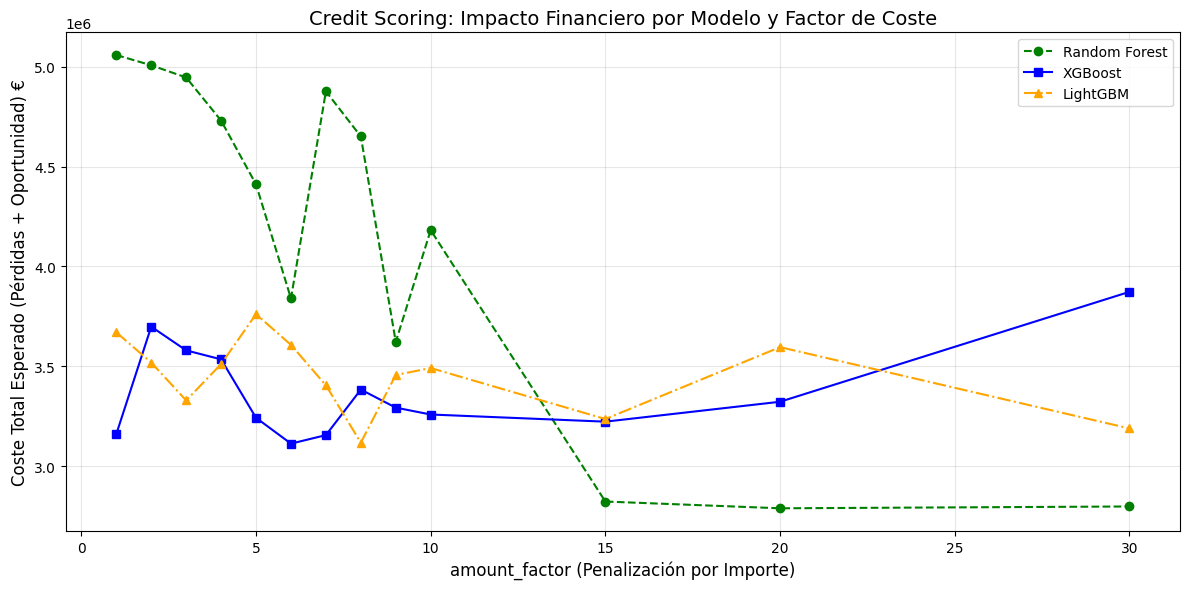

In [11]:
# 3. Gráfica Comparativa
plt.figure(figsize=(12, 6))
plt.plot(cs_factors, results_cs['rf'], 'o--', label='Random Forest', color='green')
plt.plot(cs_factors, results_cs['xgb'], 's-', label='XGBoost', color='blue')
plt.plot(cs_factors, results_cs['lgbm'], '^-.', label='LightGBM', color='orange')

plt.title('Credit Scoring: Impacto Financiero por Modelo y Factor de Coste', fontsize=14)
plt.xlabel('amount_factor (Penalización por Importe)', fontsize=12)
plt.ylabel('Coste Total Esperado (Pérdidas + Oportunidad) €', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../results/comparativa_costes_credit_scoring.png') # Guardamos la gráfica
plt.show()

In [12]:
# 4. Selección del Ganador Absoluto
min_costs = {
    'rf': min(results_cs['rf']),
    'xgb': min(results_cs['xgb']),
    'lgbm': min(results_cs['lgbm'])
}

best_model_name = min(min_costs, key=min_costs.get)
best_cost_val = min_costs[best_model_name]

# Encontrar el factor óptimo para ese modelo ganador
best_idx = np.argmin(results_cs[best_model_name])
best_factor_cs = cs_factors[best_idx]

print("\n" + "="*60)
print("🏆 RESULTADO FINAL CREDIT SCORING")
print("="*60)
print(f"Modelo Ganador: {best_model_name.upper()}")
print(f"Factor Óptimo:  {best_factor_cs}")
print(f"Coste Mínimo:   €{best_cost_val:,.0f}")


🏆 RESULTADO FINAL CREDIT SCORING
Modelo Ganador: RF
Factor Óptimo:  20
Coste Mínimo:   €2,788,300


In [9]:
# 5. Re-entrenar y Guardar el Ganador
print(f"\nGuardando el mejor modelo ({best_model_name.upper()})...")
final_cs_model = train_model_with_cost(
    X_train_cs, y_train_cs, amount_train_cs, 
    model_type=best_model_name, 
    amount_factor=best_factor_cs
)

import joblib
# Guardamos con un nombre genérico para que los siguientes notebooks lo carguen fácil
joblib.dump(final_cs_model, '../models/credit_scoring_best_model.pkl')
print("Modelo guardado en: ../models/credit_scoring_best_model.pkl")


Guardando el mejor modelo (LGBM)...
Model LGBM trained (factor=8)
Modelo guardado en: ../models/credit_scoring_best_model.pkl
